# Method 6 - Best Ideas Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

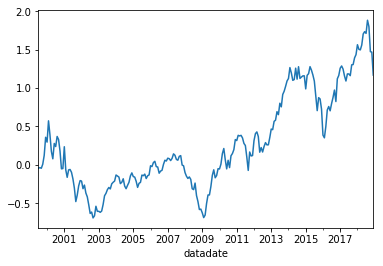

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.358329
2000-12-31   -0.299813
2001-12-31   -0.165000
2002-12-31   -0.504049
2003-12-31    1.001155
2004-12-31    0.135009
2005-12-31   -0.029852
2006-12-31    0.209142
2007-12-31   -0.059538
2008-12-31   -0.571372
2009-12-31    1.243785
2010-12-31    0.399761
2011-12-31   -0.156730
2012-12-31    0.209888
2013-12-31    0.543026
2014-12-31    0.032154
2015-12-31   -0.201049
2016-12-31    0.254185
2017-12-31    0.125504
2018-12-31   -0.109369
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     362.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.97e-98
Time:                        14:08:53   Log-Likelihood:                 438.75
No. Observations:                 234   AIC:                            -867.5
Df Residuals:                     229   BIC:                            -850.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      2.029      0.044       0.000       0.010
mktrf          1.3484      0.070     19.273      0.000       1.211       1.486
me             0.5462      0.081      6.712      0.000       0.386       0.707
ia            -0.0496      0.124     -0.401      0.689      -0.293       0.194
roe           -1.1951      0.106    -11.288      0.000      -1.404      -0.986
==============================================================================
Omnibus:                       98.640   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              569.604
Skew:                           1.556   Prob(JB):                    2.05e-124
Kurtosis:                       9.981   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     129.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-57
Time:                        14:08:53   Log-Likelihood:                 438.75
No. Observations:                 234   AIC:                            -867.5
Df Residuals:                     229   BIC:                            -850.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.935      0.053   -6.71e-05       0.010
mktrf          1.3484      0.115     11.701      0.000       1.123       1.574
me             0.5462      0.089      6.105      0.000       0.371       0.722
ia            -0.0496      0.163     -0.304      0.761      -0.369       0.270
roe           -1.1951      0.187     -6.377      0.000      -1.562      -0.828
==============================================================================
Omnibus:                       98.640   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              569.604
Skew:                           1.556   Prob(JB):                    2.05e-124
Kurtosis:                       9.981   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     138.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.07e-60
Time:                        14:08:53   Log-Likelihood:                 438.75
No. Observations:                 234   AIC:                            -867.5
Df Residuals:                     229   BIC:                            -850.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.916      0.055      -0.000       0.010
mktrf          1.3484      0.115     11.736      0.000       1.123       1.574
me             0.5462      0.101      5.429      0.000       0.349       0.743
ia            -0.0496      0.148     -0.335      0.738      -0.340       0.241
roe           -1.1951      0.197     -6.081      0.000      -1.580      -0.810
==============================================================================
Omnibus:                       98.640   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              569.604
Skew:                           1.556   Prob(JB):                    2.05e-124
Kurtosis:                       9.981   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     227.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.43e-86
Time:                        14:08:53   Log-Likelihood:                 415.19
No. Observations:                 234   AIC:                            -818.4
Df Residuals:                     228   BIC:                            -797.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.310      0.191      -0.002       0.009
mktrf          1.4830      0.078     19.088      0.000       1.330       1.636
smb            0.6348      0.103      6.193      0.000       0.433       0.837
hml            0.2764      0.121      2.287      0.023       0.038       0.515
rmw           -0.9724      0.137     -7.115      0.000      -1.242      -0.703
cma           -0.1594      0.174     -0.917      0.360      -0.502       0.183
==============================================================================
Omnibus:                      130.537   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              864.425
Skew:                           2.148   Prob(JB):                    1.96e-188
Kurtosis:                      11.379   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     129.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.65e-64
Time:                        14:08:53   Log-Likelihood:                 415.19
No. Observations:                 234   AIC:                            -818.4
Df Residuals:                     228   BIC:                            -797.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.250      0.211      -0.002       0.010
mktrf          1.4830      0.084     17.715      0.000       1.319       1.647
smb            0.6348      0.117      5.443      0.000       0.406       0.863
hml            0.2764      0.177      1.560      0.119      -0.071       0.624
rmw           -0.9724      0.217     -4.480      0.000      -1.398      -0.547
cma           -0.1594      0.290     -0.549      0.583      -0.728       0.410
==============================================================================
Omnibus:                      130.537   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              864.425
Skew:                           2.148   Prob(JB):                    1.96e-188
Kurtosis:                      11.379   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     149.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.75e-70
Time:                        14:08:53   Log-Likelihood:                 415.19
No. Observations:                 234   AIC:                            -818.4
Df Residuals:                     228   BIC:                            -797.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.194      0.232      -0.002       0.010
mktrf          1.4830      0.073     20.243      0.000       1.339       1.627
smb            0.6348      0.115      5.540      0.000       0.410       0.859
hml            0.2764      0.141      1.957      0.050      -0.000       0.553
rmw           -0.9724      0.231     -4.215      0.000      -1.425      -0.520
cma           -0.1594      0.278     -0.574      0.566      -0.703       0.385
==============================================================================
Omnibus:                      130.537   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              864.425
Skew:                           2.148   Prob(JB):                    1.96e-188
Kurtosis:                      11.379   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     321.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-92
Time:                        14:08:53   Log-Likelihood:                 426.53
No. Observations:                 234   AIC:                            -843.1
Df Residuals:                     229   BIC:                            -825.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.003      0.495      0.621      -0.004       0.006
mktrf          1.5129      0.068     22.293      0.000       1.379       1.647
smb            1.1007      0.085     12.993      0.000       0.934       1.268
hml           -0.0486      0.084     -0.577      0.564      -0.214       0.117
umd           -0.4893      0.055     -8.862      0.000      -0.598      -0.381
==============================================================================
Omnibus:                       69.170   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.443
Skew:                           1.154   Prob(JB):                     5.11e-59
Kurtosis:                       7.712   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     149.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-62
Time:                        14:08:53   Log-Likelihood:                 426.53
No. Observations:                 234   AIC:                            -843.1
Df Residuals:                     229   BIC:                            -825.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.546      0.585      -0.003       0.006
mktrf          1.5129      0.095     15.978      0.000       1.327       1.699
smb            1.1007      0.095     11.644      0.000       0.915       1.286
hml           -0.0486      0.104     -0.468      0.640      -0.252       0.155
umd           -0.4893      0.097     -5.065      0.000      -0.679      -0.300
==============================================================================
Omnibus:                       69.170   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.443
Skew:                           1.154   Prob(JB):                     5.11e-59
Kurtosis:                       7.712   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     147.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.18e-62
Time:                        14:08:53   Log-Likelihood:                 426.53
No. Observations:                 234   AIC:                            -843.1
Df Residuals:                     229   BIC:                            -825.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.583      0.560      -0.003       0.006
mktrf          1.5129      0.089     16.951      0.000       1.338       1.688
smb            1.1007      0.090     12.295      0.000       0.925       1.276
hml           -0.0486      0.093     -0.520      0.603      -0.232       0.135
umd           -0.4893      0.094     -5.230      0.000      -0.673      -0.306
==============================================================================
Omnibus:                       69.170   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.443
Skew:                           1.154   Prob(JB):                     5.11e-59
Kurtosis:                       7.712   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     170.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.28e-47
Time:                        14:08:53   Log-Likelihood:                 201.85
No. Observations:                 120   AIC:                            -393.7
Df Residuals:                     115   BIC:                            -379.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.004      2.000      0.048    8.54e-05       0.017
mktrf          1.2817      0.118     10.817      0.000       1.047       1.516
me             0.4587      0.117      3.920      0.000       0.227       0.691
ia            -0.1050      0.183     -0.573      0.568      -0.468       0.258
roe           -1.2670      0.162     -7.811      0.000      -1.588      -0.946
==============================================================================
Omnibus:                       38.207   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.331
Skew:                           1.176   Prob(JB):                     2.21e-23
Kurtosis:                       6.916   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     114.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.31e-39
Time:                        14:08:53   Log-Likelihood:                 201.85
No. Observations:                 120   AIC:                            -393.7
Df Residuals:                     115   BIC:                            -379.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.004      2.153      0.031       0.001       0.017
mktrf          1.2817      0.164      7.838      0.000       0.961       1.602
me             0.4587      0.110      4.158      0.000       0.242       0.675
ia            -0.1050      0.220     -0.477      0.633      -0.537       0.326
roe           -1.2670      0.238     -5.329      0.000      -1.733      -0.801
==============================================================================
Omnibus:                       38.207   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.331
Skew:                           1.176   Prob(JB):                     2.21e-23
Kurtosis:                       6.916   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     124.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.15e-41
Time:                        14:08:53   Log-Likelihood:                 201.85
No. Observations:                 120   AIC:                            -393.7
Df Residuals:                     115   BIC:                            -379.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.004      2.280      0.023       0.001       0.016
mktrf          1.2817      0.163      7.870      0.000       0.962       1.601
me             0.4587      0.125      3.671      0.000       0.214       0.704
ia            -0.1050      0.194     -0.541      0.588      -0.485       0.275
roe           -1.2670      0.254     -4.998      0.000      -1.764      -0.770
==============================================================================
Omnibus:                       38.207   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.331
Skew:                           1.176   Prob(JB):                     2.21e-23
Kurtosis:                       6.916   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     103.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.08e-40
Time:                        14:08:53   Log-Likelihood:                 188.38
No. Observations:                 120   AIC:                            -364.8
Df Residuals:                     114   BIC:                            -348.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.005      1.581      0.117      -0.002       0.018
mktrf          1.5871      0.140     11.304      0.000       1.309       1.865
smb            0.6220      0.159      3.911      0.000       0.307       0.937
hml            0.0968      0.195      0.497      0.620      -0.289       0.483
rmw           -0.8118      0.230     -3.533      0.001      -1.267      -0.357
cma           -0.0761      0.252     -0.302      0.763      -0.575       0.423
==============================================================================
Omnibus:                       67.041   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.251
Skew:                           2.043   Prob(JB):                     6.17e-56
Kurtosis:                       8.844   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     57.64
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.26e-29
Time:                        14:08:53   Log-Likelihood:                 188.38
No. Observations:                 120   AIC:                            -364.8
Df Residuals:                     114   BIC:                            -348.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.004      1.797      0.072      -0.001       0.017
mktrf          1.5871      0.154     10.338      0.000       1.286       1.888
smb            0.6220      0.168      3.710      0.000       0.293       0.951
hml            0.0968      0.183      0.528      0.597      -0.262       0.456
rmw           -0.8118      0.299     -2.717      0.007      -1.397      -0.226
cma           -0.0761      0.341     -0.224      0.823      -0.743       0.591
==============================================================================
Omnibus:                       67.041   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.251
Skew:                           2.043   Prob(JB):                     6.17e-56
Kurtosis:                       8.844   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     69.35
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.87e-33
Time:                        14:08:53   Log-Likelihood:                 188.38
No. Observations:                 120   AIC:                            -364.8
Df Residuals:                     114   BIC:                            -348.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.004      1.813      0.070      -0.001       0.017
mktrf          1.5871      0.126     12.613      0.000       1.340       1.834
smb            0.6220      0.164      3.792      0.000       0.300       0.943
hml            0.0968      0.167      0.579      0.563      -0.231       0.425
rmw           -0.8118      0.322     -2.519      0.012      -1.443      -0.180
cma           -0.0761      0.320     -0.238      0.812      -0.704       0.552
==============================================================================
Omnibus:                       67.041   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.251
Skew:                           2.043   Prob(JB):                     6.17e-56
Kurtosis:                       8.844   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     162.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.43e-46
Time:                        14:08:53   Log-Likelihood:                 199.38
No. Observations:                 120   AIC:                            -388.8
Df Residuals:                     115   BIC:                            -374.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.084      0.281      -0.004       0.013
mktrf          1.5602      0.107     14.642      0.000       1.349       1.771
smb            1.0857      0.121      8.949      0.000       0.845       1.326
hml           -0.1604      0.122     -1.320      0.189      -0.401       0.080
umd           -0.4737      0.075     -6.322      0.000      -0.622      -0.325
==============================================================================
Omnibus:                       35.814   Durbin-Watson:                   2.169
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.343
Skew:                           1.106   Prob(JB):                     1.98e-21
Kurtosis:                       6.765   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     122.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.66e-40
Time:                        14:08:53   Log-Likelihood:                 199.38
No. Observations:                 120   AIC:                            -388.8
Df Residuals:                     115   BIC:                            -374.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.404      0.160      -0.002       0.011
mktrf          1.5602      0.147     10.601      0.000       1.272       1.849
smb            1.0857      0.119      9.126      0.000       0.853       1.319
hml           -0.1604      0.137     -1.174      0.241      -0.428       0.108
umd           -0.4737      0.100     -4.742      0.000      -0.669      -0.278
==============================================================================
Omnibus:                       35.814   Durbin-Watson:                   2.169
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.343
Skew:                           1.106   Prob(JB):                     1.98e-21
Kurtosis:                       6.765   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     131.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.47e-42
Time:                        14:08:53   Log-Likelihood:                 199.38
No. Observations:                 120   AIC:                            -388.8
Df Residuals:                     115   BIC:                            -374.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.618      0.106      -0.001       0.011
mktrf          1.5602      0.143     10.939      0.000       1.281       1.840
smb            1.0857      0.106     10.216      0.000       0.877       1.294
hml           -0.1604      0.130     -1.235      0.217      -0.415       0.094
umd           -0.4737      0.096     -4.943      0.000      -0.662      -0.286
==============================================================================
Omnibus:                       35.814   Durbin-Watson:                   2.169
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.343
Skew:                           1.106   Prob(JB):                     1.98e-21
Kurtosis:                       6.765   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     223.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.55e-51
Time:                        14:08:53   Log-Likelihood:                 257.30
No. Observations:                 114   AIC:                            -504.6
Df Residuals:                     109   BIC:                            -490.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.655      0.514      -0.003       0.007
mktrf          1.3995      0.076     18.380      0.000       1.249       1.550
me             0.7094      0.118      6.034      0.000       0.476       0.942
ia             0.0120      0.163      0.073      0.942      -0.311       0.335
roe           -1.1197      0.143     -7.815      0.000      -1.404      -0.836
==============================================================================
Omnibus:                       38.658   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.556
Skew:                           1.224   Prob(JB):                     2.68e-24
Kurtosis:                       7.106   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     160.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.30e-45
Time:                        14:08:53   Log-Likelihood:                 257.30
No. Observations:                 114   AIC:                            -504.6
Df Residuals:                     109   BIC:                            -490.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.712      0.477      -0.003       0.006
mktrf          1.3995      0.109     12.821      0.000       1.186       1.613
me             0.7094      0.134      5.306      0.000       0.447       0.971
ia             0.0120      0.194      0.062      0.951      -0.368       0.392
roe           -1.1197      0.182     -6.143      0.000      -1.477      -0.762
==============================================================================
Omnibus:                       38.658   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.556
Skew:                           1.224   Prob(JB):                     2.68e-24
Kurtosis:                       7.106   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     174.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.07e-46
Time:                        14:08:53   Log-Likelihood:                 257.30
No. Observations:                 114   AIC:                            -504.6
Df Residuals:                     109   BIC:                            -490.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.741      0.459      -0.003       0.006
mktrf          1.3995      0.107     13.030      0.000       1.189       1.610
me             0.7094      0.155      4.580      0.000       0.406       1.013
ia             0.0120      0.215      0.056      0.956      -0.410       0.434
roe           -1.1197      0.188     -5.970      0.000      -1.487      -0.752
==============================================================================
Omnibus:                       38.658   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.556
Skew:                           1.224   Prob(JB):                     2.68e-24
Kurtosis:                       7.106   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     162.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.52e-48
Time:                        14:08:53   Log-Likelihood:                 252.94
No. Observations:                 114   AIC:                            -493.9
Df Residuals:                     108   BIC:                            -477.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.931e-05      0.003     -0.037      0.971      -0.005       0.005
mktrf          1.4295      0.076     18.858      0.000       1.279       1.580
smb            0.6521      0.123      5.299      0.000       0.408       0.896
hml            0.4975      0.157      3.170      0.002       0.186       0.809
rmw           -1.0805      0.192     -5.623      0.000      -1.461      -0.700
cma           -0.2879      0.244     -1.180      0.240      -0.771       0.196
==============================================================================
Omnibus:                       10.818   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.555
Skew:                           0.530   Prob(JB):                      0.00114
Kurtosis:                       4.316   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     107.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.15e-40
Time:                        14:08:53   Log-Likelihood:                 252.94
No. Observations:                 114   AIC:                            -493.9
Df Residuals:                     108   BIC:                            -477.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.931e-05      0.003     -0.030      0.976      -0.007       0.006
mktrf          1.4295      0.081     17.559      0.000       1.270       1.589
smb            0.6521      0.114      5.714      0.000       0.428       0.876
hml            0.4975      0.169      2.940      0.003       0.166       0.829
rmw           -1.0805      0.224     -4.820      0.000      -1.520      -0.641
cma           -0.2879      0.241     -1.195      0.232      -0.760       0.184
==============================================================================
Omnibus:                       10.818   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.555
Skew:                           0.530   Prob(JB):                      0.00114
Kurtosis:                       4.316   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     100.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.31e-39
Time:                        14:08:53   Log-Likelihood:                 252.94
No. Observations:                 114   AIC:                            -493.9
Df Residuals:                     108   BIC:                            -477.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.931e-05      0.003     -0.029      0.976      -0.007       0.007
mktrf          1.4295      0.082     17.411      0.000       1.269       1.590
smb            0.6521      0.124      5.263      0.000       0.409       0.895
hml            0.4975      0.154      3.229      0.001       0.195       0.799
rmw           -1.0805      0.193     -5.610      0.000      -1.458      -0.703
cma           -0.2879      0.274     -1.052      0.293      -0.824       0.248
==============================================================================
Omnibus:                       10.818   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.555
Skew:                           0.530   Prob(JB):                      0.00114
Kurtosis:                       4.316   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     177.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.28e-47
Time:                        14:08:53   Log-Likelihood:                 245.89
No. Observations:                 114   AIC:                            -481.8
Df Residuals:                     109   BIC:                            -468.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.003     -0.359      0.720      -0.007       0.005
mktrf          1.4610      0.080     18.318      0.000       1.303       1.619
smb            0.9143      0.124      7.352      0.000       0.668       1.161
hml            0.3450      0.128      2.693      0.008       0.091       0.599
umd           -0.4346      0.097     -4.498      0.000      -0.626      -0.243
==============================================================================
Omnibus:                       12.811   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               18.590
Skew:                           0.552   Prob(JB):                     9.19e-05
Kurtosis:                       4.642   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     165.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.68e-45
Time:                        14:08:53   Log-Likelihood:                 245.89
No. Observations:                 114   AIC:                            -481.8
Df Residuals:                     109   BIC:                            -468.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.003     -0.360      0.719      -0.007       0.005
mktrf          1.4610      0.087     16.739      0.000       1.290       1.632
smb            0.9143      0.120      7.591      0.000       0.678       1.150
hml            0.3450      0.176      1.957      0.050      -0.001       0.691
umd           -0.4346      0.118     -3.678      0.000      -0.666      -0.203
==============================================================================
Omnibus:                       12.811   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               18.590
Skew:                           0.552   Prob(JB):                     9.19e-05
Kurtosis:                       4.642   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     214.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.80e-51
Time:                        14:08:53   Log-Likelihood:                 245.89
No. Observations:                 114   AIC:                            -481.8
Df Residuals:                     109   BIC:                            -468.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.003     -0.353      0.724      -0.007       0.005
mktrf          1.4610      0.084     17.364      0.000       1.296       1.626
smb            0.9143      0.110      8.308      0.000       0.699       1.130
hml            0.3450      0.181      1.911      0.056      -0.009       0.699
umd           -0.4346      0.123     -3.537      0.000      -0.675      -0.194
==============================================================================
Omnibus:                       12.811   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               18.590
Skew:                           0.552   Prob(JB):                     9.19e-05
Kurtosis:                       4.642   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""